In [1]:
#Note: this notebook is like graph1, but it will specifically process particular tokens in the loss_per_token_scored.csv file

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
sns.set()
# sns.set_context('paper', font_scale=0.73)
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
!echo $CONDA_DEFAULT_ENV

In [1]:
#paths
root_dir = "/mnt/nfs1/ryan/haveibeentrainedon/models_old"
group_folder = "watermark_length_final"
exp_name= ["pile1e8_10len", "pile1e8_20len", "pile1e8_40len","pile1e8_80len"]

dataset_names = []
for exp in exp_name:
    dataset_names += [f"{exp}_seed0", f"{exp}_seed1", f"{exp}_seed2", f"{exp}_seed3", f"{exp}_seed4"]
model_sizes = ["70M"]
scored_file = "loss_per_token_scored.csv"

#these are the tokens that we will be averaging the losses to get our statistic
start_attend = 0
end_attend = 100

experiments = [f"{root_dir}/{group_folder}/{dataset_name}/{model_size}" for model_size in model_sizes for dataset_name in dataset_names]
experiments

['/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_10len_seed0/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_10len_seed1/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_10len_seed2/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_10len_seed3/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_10len_seed4/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_20len_seed0/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_20len_seed1/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_20len_seed2/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_20len_seed3/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models_old/watermark_length_final/pile1e8_20len_seed4/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/mode

In [4]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(experiments[0])))
models = sorted(models, key = lambda x: eval(x[:-6]))
models

['256_model']

In [5]:
def read_file(file_name):
    data = []
    with open(file_name, 'r') as file:
        for line in file:
            row = [eval(element.strip()) for element in line.split(",")]
            data.append(row[start_attend:end_attend])
    return data

In [6]:
experiments_dfs = []
for experiment in experiments:
    model_dfs = []
    for model_type in models:
        model_dfs += [read_file(os.path.join(experiment,  model_type, scored_file))]
    experiments_dfs.append(model_dfs)
print(len(experiments_dfs))
print(len(model_dfs))

20
1


In [16]:

y_axises = []
null_means = []
null_stdev = []
statistic_total = []
for experiment_dfs in experiments_dfs:
    y_axis = []
    null_raw = []
    null_std = []
    statistic_temp = []
    for model_df in experiment_dfs:
        null_raw = model_df[1:]
        #we first average over tokens to get average loss per each example
        null = [statistics.mean(row) for row in null_raw]

        #we then calculate the average and stdev of this null distribution
        mean = statistics.mean(null)
        stdev = statistics.stdev(null)

        statistic = statistics.mean(model_df[0])
        # print(f"statistic = {statistic}, mean = {mean}, stdev = {stdev}")

        statistic_temp += [statistic]

        y_axis += [(statistic - mean) / stdev]
        null_means += [mean]
        null_std += [stdev]
    y_axises.append(y_axis)
    statistic_total.append(statistic_temp)
    null_stdev.append(null_std)

print(len(y_axises[0]))

1


In [17]:
y_axises = np.array(y_axises).reshape(len(exp_name), -1)

In [18]:
y_axises

array([[ -3.11873203,  -4.13756576,  -4.36509866,  -4.28834025,
         -4.76705024],
       [ -7.09087092,  -7.6060597 ,  -7.26258479,  -7.70278601,
         -8.2858706 ],
       [-11.4561045 , -11.50640719, -13.67221474, -11.14928379,
        -12.70064984],
       [-17.25240805, -19.20327001, -20.62033835, -17.91545068,
        -18.96072787]])

In [20]:
y_axises.mean(axis=1)


array([ -4.13535739,  -7.58963441, -12.09693201, -18.79043899])

In [21]:
y_axises.std(axis=1)

array([0.54931824, 0.41316931, 0.94904241, 1.15577707])

In [24]:
null_means = np.array(null_means).reshape(len(exp_name), -1)

In [25]:
null_means.mean(axis=1)


array([7.8738516 , 7.7708996 , 7.48280257, 7.32005961])

In [26]:
null_means.std(axis=1)

array([0.06817196, 0.06732457, 0.1219488 , 0.05132433])

In [27]:
null_stdev = np.array(null_stdev).reshape(len(exp_name), -1)

In [28]:
null_stdev.mean(axis=1)

array([1.09173905, 0.8002395 , 0.54319035, 0.36383049])

In [29]:
null_stdev.std(axis=1)

array([0.03777099, 0.04614765, 0.04645482, 0.02100447])

In [30]:
statistic_total = np.array(statistic_total).reshape(len(exp_name), -1)

In [31]:
statistic_total.mean(axis=1)


array([3.3568474 , 1.70755435, 0.95394247, 0.50773179])

In [32]:
statistic_total.std(axis=1)

array([0.62423278, 0.28227495, 0.16082998, 0.04465337])

In [33]:
np.array(y_axises)

array([[ -3.11873203,  -4.13756576,  -4.36509866,  -4.28834025,
         -4.76705024],
       [ -7.09087092,  -7.6060597 ,  -7.26258479,  -7.70278601,
         -8.2858706 ],
       [-11.4561045 , -11.50640719, -13.67221474, -11.14928379,
        -12.70064984],
       [-17.25240805, -19.20327001, -20.62033835, -17.91545068,
        -18.96072787]])

In [34]:
averaged = np.array(y_axises).mean(axis=1)
averaged

array([ -4.13535739,  -7.58963441, -12.09693201, -18.79043899])

In [35]:
x_axis = [10, 20, 40, 80]

print(x_axis)

[10, 20, 40, 80]


No handles with labels found to put in legend.


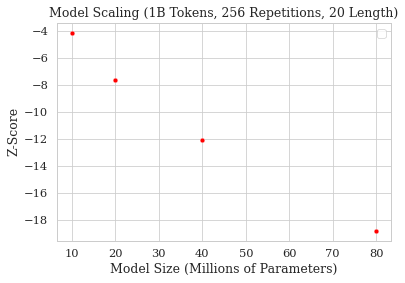

In [36]:
# Create a line plot for each set of y-values
sns.scatterplot(x=x_axis, y=averaged, color='red')

# sns.scatterplot(x=x_axis, y=y_axises[0], color='red', label='70M')
# ax = sns.lineplot(x=x_axis, y=y_axises[1], color='blue', label='160M')
# sns.scatterplot(x=x_axis, y=y_axises[2], color='green', label='30char')

# Customize the plot
plt.title('Model Scaling (1B Tokens, 256 Repetitions, 20 Length)')
plt.xlabel('Model Size (Millions of Parameters)')
plt.ylabel('Z-Score')
plt.legend()

# Show the plot
plt.show()

In [25]:
np.array(y_axises).mean()

-8.709461298761209